RNN exo

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

## Data

Info about this data set: https://fred.stlouisfed.org/series/IPN31152N


Units:  Index 2012=100, Not Seasonally Adjusted

Frequency:  Monthly

The industrial production (IP) index measures the real output of all relevant establishments located in the United States, regardless of their ownership, but not those located in U.S. territories.

NAICS = 31152

Source Code: IP.N31152.N

Suggested Citation:
Board of Governors of the Federal Reserve System (US), Industrial Production: Nondurable Goods: Ice cream and frozen dessert [IPN31152N], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/IPN31152N, November 16, 2019.



In [8]:
#import data

df = pd.read_csv('/content/Frozen_Dessert_Production.csv',index_col='DATE',parse_dates=True)

In [9]:
df.head()

,IPN31152N
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 573 entries, 1972-01-01 to 2019-09-01
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   IPN31152N  573 non-null    float64
dtypes: float64(1)
memory usage: 9.0 KB


In [12]:
df.columns

Index(['IPN31152N'], dtype='object')

In [13]:
#change the name to production

In [14]:
df.columns = ['Production']

In [15]:
df.head()

,Production
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636


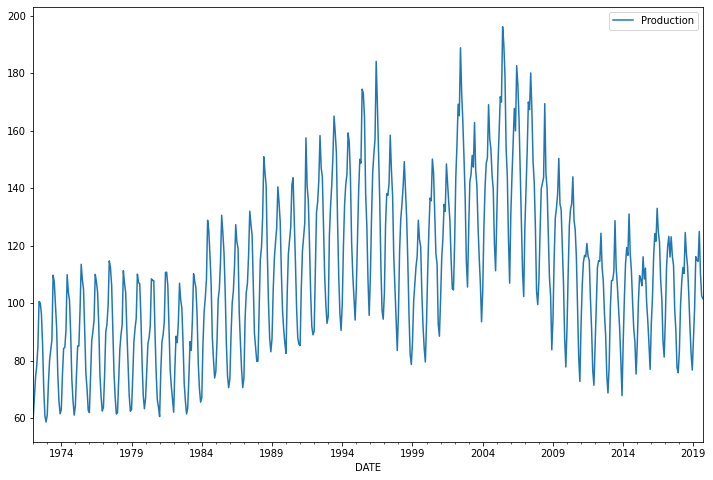

In [17]:
df.plot(figsize=(12,8))

# Train Test split

In [18]:
df.shape

(573, 1)

In [19]:
len(df)

573

In [20]:
#we will split as the test data is the 24 last month 

In [57]:
test_size = 18#change now to 18

In [58]:
test_index = len(df) - test_size

In [59]:
train = df.iloc[:test_index]
test = df.iloc[test_index:]

In [60]:
len(test)

18

Scale data

In [61]:
from sklearn.preprocessing import MinMaxScaler

In [62]:
scaler = MinMaxScaler()

In [63]:
scaler.fit(train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [64]:
scaled_train = scaler.transform(train)

scaled_test = scaler.transform(test)

## Time series generator

## Create a TimeSeriesGenerator object based off the scaled_train data. The batch length is up to you, but at a minimum it should be at least 18 to capture a full year seasonality

In [65]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [66]:
length = 12 #now we change to 12
n_features=1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)

## Create the model

In [67]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [68]:
model = Sequential()

model.add(LSTM(150,input_shape=(length,n_features)))

model.add(Dense(1))


model.compile(optimizer='adam',loss='mse')

In [69]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 150)               91200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 151       
Total params: 91,351
Trainable params: 91,351
Non-trainable params: 0
_________________________________________________________________


In [70]:
validation_generator = TimeseriesGenerator(scaled_test,scaled_test,length=length,batch_size=1)

In [71]:
from tensorflow.keras.callbacks import EarlyStopping

In [72]:
early_stop = EarlyStopping(monitor='val_loss', patience=2)

In [73]:
model.fit_generator(generator,epochs=20,
                    validation_data= validation_generator,
                    callbacks = [early_stop])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
543/543 [==============================] - 7s 9ms/step - loss: 0.0286 - val_loss: 0.0018
Epoch 2/20
543/543 [==============================] - 4s 8ms/step - loss: 0.0040 - val_loss: 0.0030
Epoch 3/20
543/543 [==============================] - 4s 8ms/step - loss: 0.0034 - val_loss: 0.0021


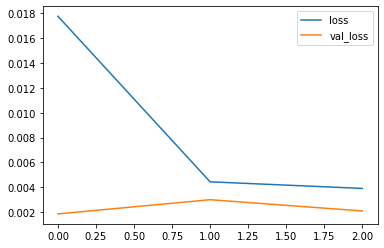

In [74]:
loss = pd.DataFrame(model.history.history)
loss.plot()

## Evaluate on test data

**TASK: Forecast predictions for your test data range (the last 12 months of the entire dataset). Remember to inverse your scaling transformations. Your final result should be a DataFrame with two columns, the true test values and the predictions.**

In [75]:
scaled_train[-length:]

array([[0.4695409 ],
       [0.41743926],
       [0.46851409],
       [0.41889656],
       [0.39641011],
       [0.28544533],
       [0.23134679],
       [0.13655347],
       [0.12472921],
       [0.18015997],
       [0.29691617],
       [0.35382169]])

In [76]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [77]:
test_predictions

[array([0.42262015], dtype=float32),
 array([0.46135333], dtype=float32),
 array([0.4743787], dtype=float32),
 array([0.44749418], dtype=float32),
 array([0.38799983], dtype=float32),
 array([0.3055513], dtype=float32),
 array([0.23226982], dtype=float32),
 array([0.19046696], dtype=float32),
 array([0.19829397], dtype=float32),
 array([0.24563006], dtype=float32),
 array([0.3132331], dtype=float32),
 array([0.38093653], dtype=float32),
 array([0.43900976], dtype=float32),
 array([0.47497398], dtype=float32),
 array([0.4811508], dtype=float32),
 array([0.45345902], dtype=float32),
 array([0.39654756], dtype=float32),
 array([0.32582146], dtype=float32)]

In [78]:
#inverse our predictions with transform
true_predictions  = scaler.inverse_transform(test_predictions)

In [79]:
test['Predictions'] = true_predictions

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [80]:
test

,Production,Predictions
DATE,,
2018-04-01,112.4309,116.775945
2018-05-01,110.3544,122.102296
2018-06-01,124.5841,123.893466
2018-07-01,117.2215,120.196470
2018-08-01,112.6779,112.015170
2018-09-01,103.3118,100.677350
2018-10-01,92.1321,90.600129
2018-11-01,82.4347,84.851654
2018-12-01,76.7608,85.927977


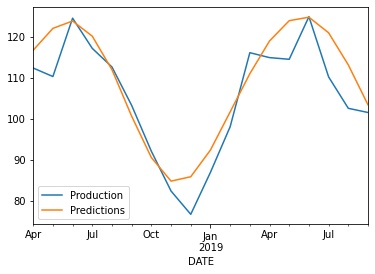

In [81]:
#lets plot our true prediction vs our true value
test.plot()

In [82]:
#Lets calculate our RMSE
from sklearn.metrics import mean_squared_error

In [83]:
np.sqrt(mean_squared_error(test['Production'], test['Predictions']))# we passed from 16 to 6 by changing the lentgh and adding 50 neurons

6.10594541614176